# Data analysis for introduction and Chapter "General Ensemble Properties"

This notebook can be used to reproduce the data analysis of the introduction and Chapter "General Ensemble Properties" of the technical report ["Assessing a Formal Model of Reflective Equilibrium"](https://re-models.github.io/re-technical-report/). 

## How to run this notebook

There are several possibilities to execute this notebook. You can, for instance,

1. execute this notebook on Colab: [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/re-models/re-technical-report/blob/main/notebooks/chapter_general-props.ipynb), or
2. execute this notebook locally in, for instance, [JupyterLab](https://jupyter.org/) by cloning the Github repository of the report (for details, see <https://github.com/re-models/re-technical-report>).

Note, however, that Colab is not suited to analyse the full data set that is used in the report. Instead, you can only use the subdata set `TINY` (see <https://github.com/re-models/re-technical-report> for details).

## Installing and importing libraries

In [1]:
!pip install re-technical-report

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for re-technical-report from https://files.pythonhosted.org/packages/76/c3/160e07a2c7470681adefc03fb46dae7586bfffa150975bb7ccb3e08a6299/re_technical_report-0.0.6a1-py3-none-any.whl.metadata
  Obtaining dependency information for rethon from https://files.pythonhosted.org/packages/3b/85/bb1ac4079d401e7da46ae2f2d260cf9c265e73eeb3f06548d2a8cb279f84/rethon-0.0.1a1-py3-none-any.whl.metadata
  Obtaining dependency information for Deprecated from https://files.pythonhosted.org/packages/20/8d/778b7d51b981a96554f29136cd59ca7880bf58094338085bcf2a979a0e6a/Deprecated-1.2.14-py2.py3-none-any.whl.metadata
  Obtaining dependency information for theodias from https://files.pythonhosted.org/packages/32/2b/32f86b1d2b845ec5ff94b23b669654c34dfb61721eb4333033ece80c5ad7/theodias-0.0.1a1-py3-none-any.whl.metadata
  Obtaining dependency information for wrapt<2,>=1.10 from https://files.pythonhosted

In [1]:
# importing libraries
from pandas import Series, DataFrame
import pandas as pd
import numpy as np
from os import getcwd, path
from pathlib import Path
from statistics import mean
from ast import literal_eval

import matplotlib.pyplot as plt
import seaborn as sns

from re_technical_report import (
    re_data_by_name, 
    plot_multiple_error_bars,
    mean_simple_hamming_adjacents,
    heat_maps_by_weights,
    mean_simple_hamming_distance,
    mean_d_init_coms_go,
    set_errorbar_plot_style,
    set_heatmap_plot_style,
)


In [2]:
# Directories that are use to save generated tables and figures.
tables_output_dir = path.join(Path(getcwd()).parent.absolute(), "report", "tables")
figures_output_dir = path.join(Path(getcwd()).parent.absolute(), "report", "figures")

# Are we on Colab?
on_colab = 'google.colab' in str(get_ipython())
# Configuring sns styles
set_errorbar_plot_style()
set_heatmap_plot_style()

## Loading data

In [5]:
# Columns relevant for this notebook.
usecols = ['model_name', 'ds', 'init_coms', 'n_sentence_pool', 'error_code' , 'process_length', 
           'weight_account', 'weight_systematicity', 'weight_faithfulness',
           'ds_infer_dens', 'init_coms_size', 'init_coms_dia_consistent', 'n_global_optima',
           'init_final_coms_simple_hamming', 'n_fixed_points',
            'coms_evolution',#'theory_evolution',
           'global_optima']

In [7]:
# data_name: one of 'TINY', 'MINI', 'FULL'
re_data = re_data_by_name(data_name="TINY", 
                          usecols=usecols,
                          data_dir=path.join(Path(getcwd()).parent.absolute(), "data"),
                          filter_erroneous_runs=False)

In [9]:
print(f"The data set contains {sum(re_data['error_code'].isna()==False)}/{len(re_data)} rows of erroneous model runs.")
# filter
re_data = re_data.loc[re_data['error_code'].isna()]

The data set contains 2765/4139312 rows of erroneous model runs.


In [10]:
print('\033[1m' + 'General information: ' + '\033[0m')
print("   Amount of rows:" , len(re_data))
print('   Number of dialectical structures:', len(re_data['ds'].unique()))
print('   Overall number of initial commitments:', len(re_data['init_coms'].unique()))
print('   Sentence-pools:' , re_data['n_sentence_pool'].unique())
print('   Models:' , re_data['model_name'].unique())

General information: 
   Amount of rows: 4136547
   Number of dialectical structures: 200
   Overall number of initial commitments: 80
   Sentence-pools: [6 7 8 9]
   Models: ['QuadraticGlobalRE' 'LinearGlobalRE' 'QuadraticLocalRE' 'LinearLocalRE']


In [11]:
# counting simulation setups
re_data_unique_setups = re_data.drop_duplicates(["model_name",
                         "ds",
                         "n_sentence_pool",
                         'weight_account', 
                         'weight_systematicity',
                         'weight_faithfulness', 
                         'init_coms'
                        ])
re_data_unique_setups.groupby(['model_name']).size()

model_name
LinearGlobalRE       143973
LinearLocalRE        142219
QuadraticGlobalRE    143964
QuadraticLocalRE     143079
dtype: int64

In [12]:
# For the global optima we want to compare linear and quadratic variants. For a proper labeling we include another columns.
# df["group"] = df["group"].map({0: "zero", 1; "one"})
re_data['q_or_l_model'] = re_data['model_name'].map({'QuadraticGlobalRE':'QuadraticRE', 
                                                     'LinearGlobalRE':'LinearRE', 
                                                     'QuadraticLocalRE':'QuadraticRE', 
                                                     'LinearLocalRE':'LinearRE'})

## Dialectical structures

### Distribution: inferential density

In [9]:
re_data.drop_duplicates(["ds"])["ds_infer_dens"].describe()

count    200.000000
mean       0.292580
std        0.093550
min        0.151486
25%        0.211227
50%        0.272054
75%        0.367396
max        0.497382
Name: ds_infer_dens, dtype: float64

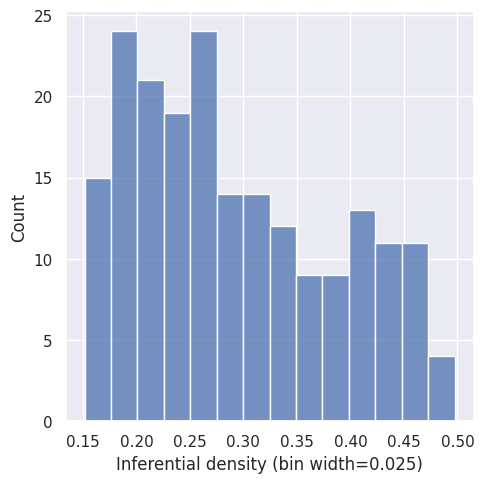

In [10]:
#re_data.drop_duplicates(["ds", "ds_infer_dens"])
g = sns.displot(re_data.drop_duplicates(["ds"]), x="ds_infer_dens", binwidth=0.025)#, discrete=True) 
g.set_axis_labels(x_var='Inferential density (bin width=0.025)')
if not on_colab:
    g.savefig(path.join(figures_output_dir, 'distr-inf-dens.pdf'), bbox_inches='tight')
    g.savefig(path.join(figures_output_dir, 'distr-inf-dens.png'), bbox_inches='tight')

### Distribution: mean number of premises

count    200.000000
mean       1.486990
std        0.377593
min        1.000000
25%        1.125000
50%        1.500000
75%        1.857143
max        2.000000
Name: ds, dtype: float64

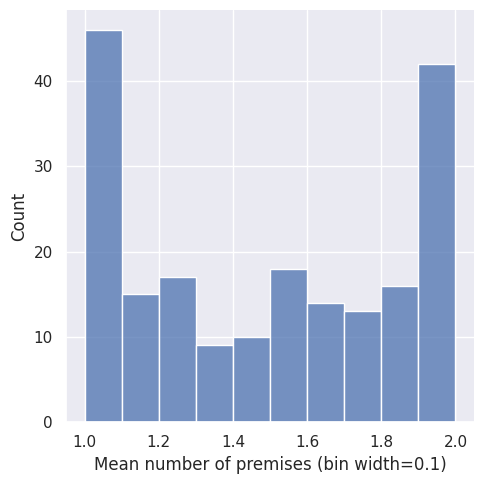

In [11]:
# WARNING: do not use `literal_eval` on unsave/unknown data
ser_ds = re_data.drop_duplicates(["ds"])["ds"]
ser_ds = ser_ds.apply(lambda x: literal_eval(x))
ser_ds = ser_ds.apply(lambda tau: mean([len(arg)-1 for arg in tau]))
display(ser_ds.describe())
#display(ser_ds)
g = sns.displot(ser_ds, binwidth=0.1)
g.set_axis_labels(x_var='Mean number of premises (bin width=0.1)')
if not on_colab:
    g.savefig(path.join(figures_output_dir, 'mean-number-premises.pdf'), bbox_inches='tight')
    g.savefig(path.join(figures_output_dir, 'mean-number-premises.png'), bbox_inches='tight')

## Initial commitments

### Consistency

In [12]:
# mean number of dialectically consistent positions
print(sum(re_data.drop_duplicates(["init_coms","ds"])["init_coms_dia_consistent"])/len(re_data.drop_duplicates(["init_coms","ds"])["init_coms_dia_consistent"]))
#re_data.drop_duplicates(["init_coms","ds"])["init_coms_dia_consistent"].describe()

0.55025


In [13]:
re_data.drop_duplicates(["init_coms","ds","n_sentence_pool"])[["init_coms","ds","n_sentence_pool","init_coms_dia_consistent"]].head()


,init_coms,ds,n_sentence_pool,init_coms_dia_consistent
0,"(1, 3, -2, -5)","[[-6, 3], [1, 3], [2, 6], [5, 6], [4, 6], [5, ...",6,True
1,"(2, -5, 6)","[[-6, 3], [1, 3], [2, 6], [5, 6], [4, 6], [5, ...",6,True
2,"(2, -5, -4, -3)","[[-6, 3], [1, 3], [2, 6], [5, 6], [4, 6], [5, ...",6,True
4,"(5, -4, -3, -1)","[[-6, 3], [1, 3], [2, 6], [5, 6], [4, 6], [5, ...",6,True
6,"(2, -3)","[[-6, 3], [1, 3], [2, 6], [5, 6], [4, 6], [5, ...",6,True


,init_coms_dia_consistent
n_sentence_pool,
6,0.623
7,0.616
8,0.506
9,0.456


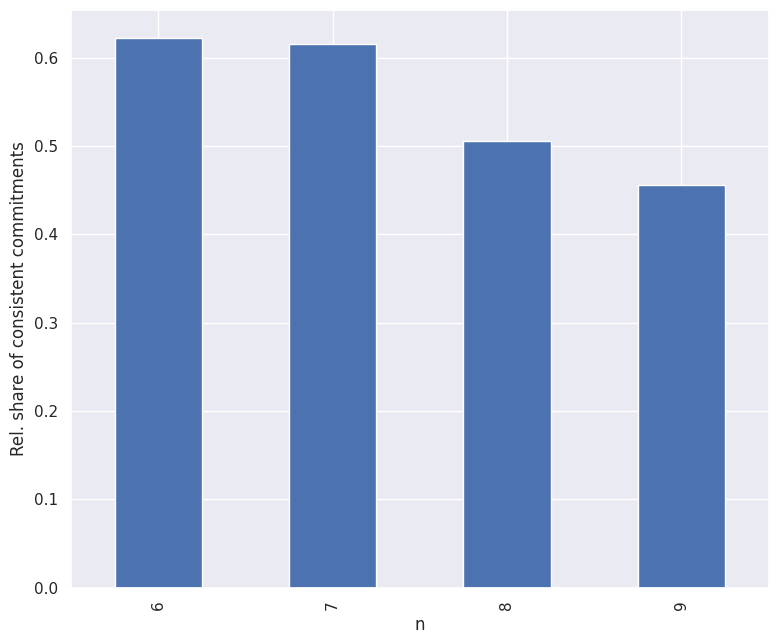

In [14]:
# mean number for different sentence pools
#rel_consistent_coms = re_data.drop_duplicates(["init_coms","ds","n_sentence_pool"])[["init_coms","ds","n_sentence_pool","init_coms_dia_consistent"]].groupby("n_sentence_pool").mean()
rel_consistent_coms = re_data.drop_duplicates(["init_coms","ds","n_sentence_pool"])[["n_sentence_pool","init_coms_dia_consistent"]].groupby("n_sentence_pool").mean()

display(rel_consistent_coms)
ax = rel_consistent_coms.plot(kind="bar")
plt.xlabel ('n')
plt.ylabel ('Rel. share of consistent commitments')
ax.get_legend().remove()

if not on_colab:
    plt.savefig(path.join(figures_output_dir, 'consistency-init-coms.pdf'), bbox_inches='tight')
    plt.savefig(path.join(figures_output_dir, 'consistency-init-coms.png'), bbox_inches='tight')

### Size of initial commitments

In [15]:
re_data.drop_duplicates(["init_coms"])['init_coms_size'].describe()

count    80.00000
mean      4.91250
std       1.49424
min       2.00000
25%       4.00000
50%       5.00000
75%       6.00000
max       9.00000
Name: init_coms_size, dtype: float64

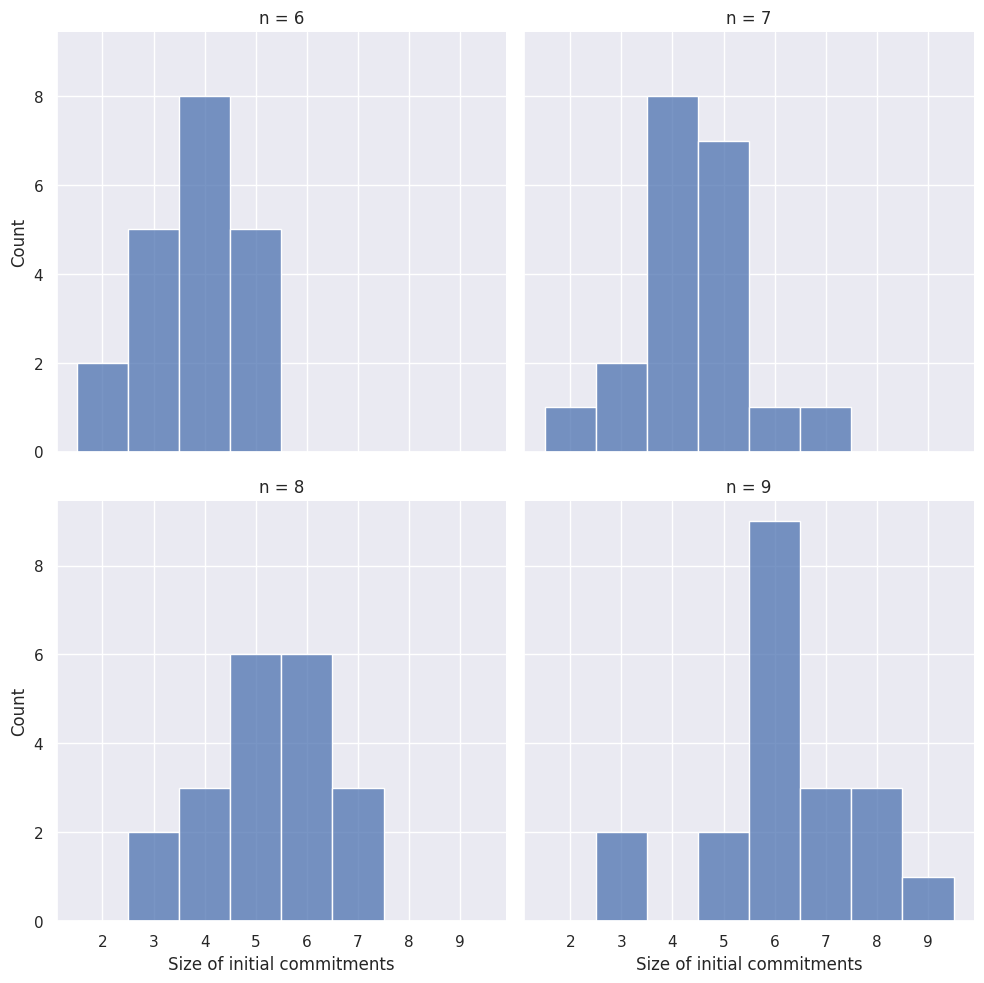

In [16]:
g = sns.displot(re_data.drop_duplicates(['init_coms', 'n_sentence_pool']), x='init_coms_size', 
            col='n_sentence_pool', col_wrap=2, discrete=True) 
g.set_axis_labels(x_var='Size of initial commitments')
#g.set_titles(row_template=f'{col_var}')
g.set_titles("n = {col_name}")
if not on_colab:
    g.savefig(path.join(figures_output_dir, 'size-init-coms.pdf'), bbox_inches='tight')
    g.savefig(path.join(figures_output_dir, 'size-init-coms.png'), bbox_inches='tight')

## Process length

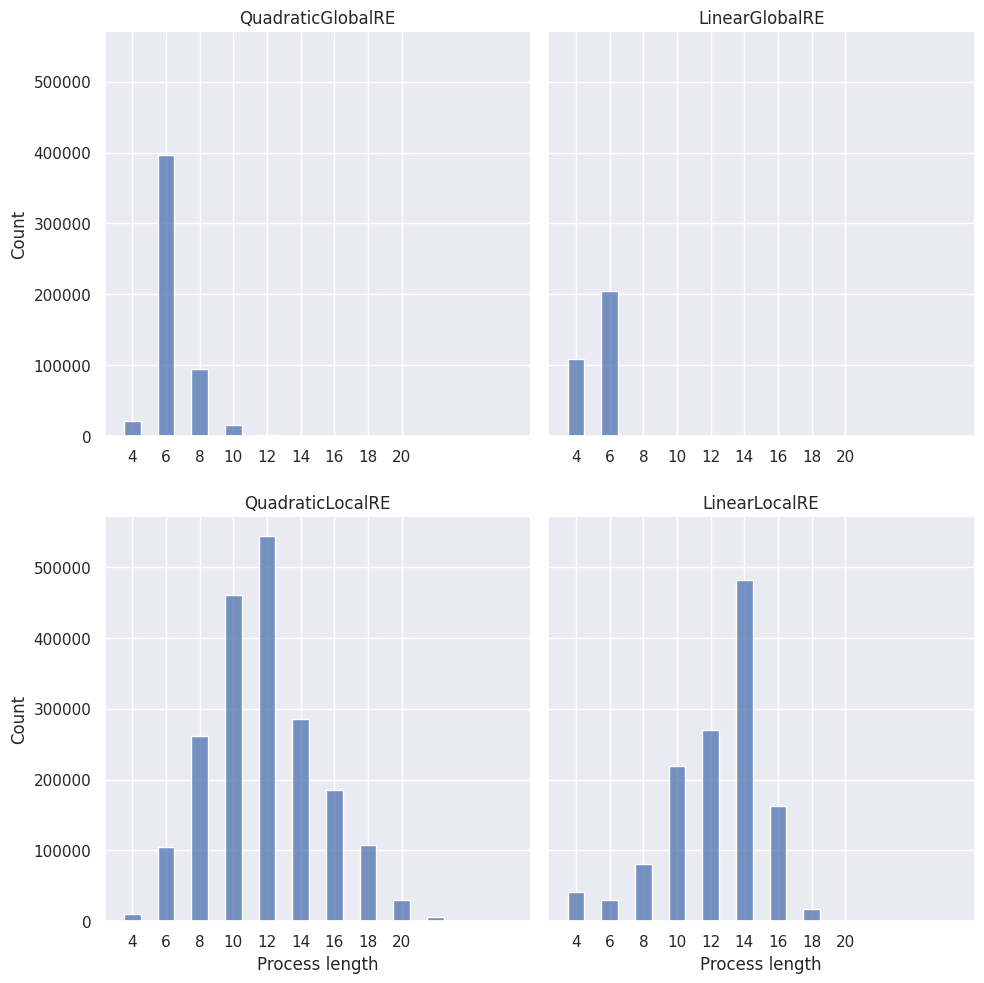

In [17]:
g = sns.displot(re_data, x='process_length', col='model_name', 
                col_wrap=2, discrete=True) 
g.set_axis_labels(x_var='Process length')
g.set_titles("{col_name}")
plt.xticks([i*2 for i in range(2,11)])
for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True)
plt.subplots_adjust(hspace=0.2)
if not on_colab:
    g.savefig(path.join(figures_output_dir, 'dist-process-length.pdf'), bbox_inches='tight')
    g.savefig(path.join(figures_output_dir, 'dist-process-length.png'), bbox_inches='tight')

Here, we consider all branches.

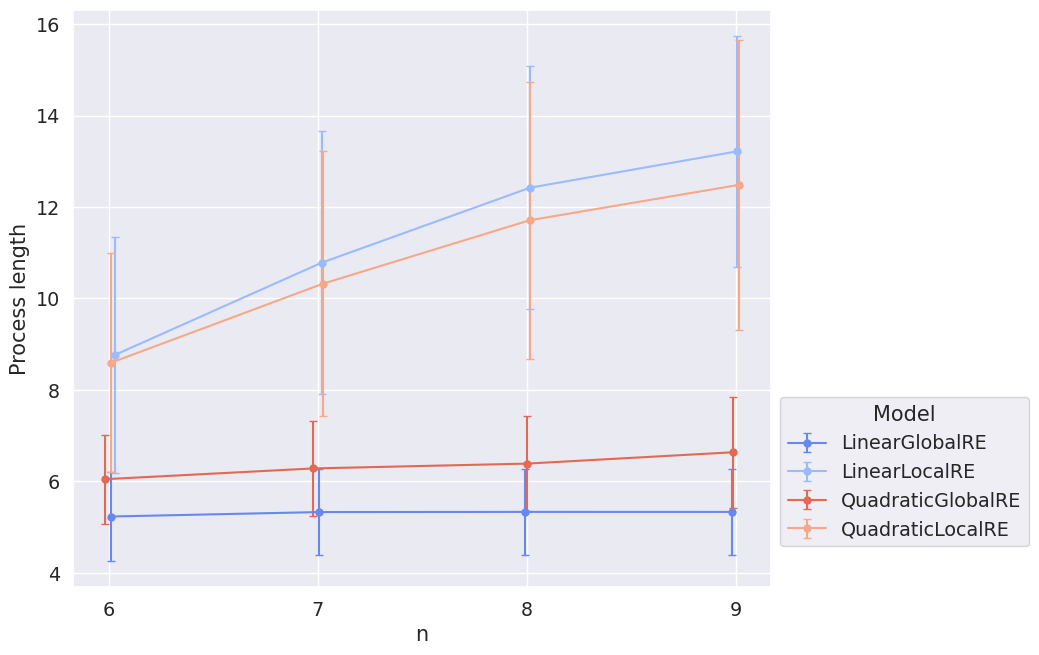

In [18]:
plot_multiple_error_bars(data=re_data, 
                         var_y='process_length', 
                         ylabel='Process length',
                         file_name=None if on_colab else 'process-length', 
                         output_dir=figures_output_dir)

## Step length

In [19]:
# for each branch: the mean distance between adjacent commitments in the evolution of commitments
re_data['mean_step_size_coms'] = re_data.apply(lambda x: mean_simple_hamming_adjacents(list(x['coms_evolution'])[:-1]), axis = 1)

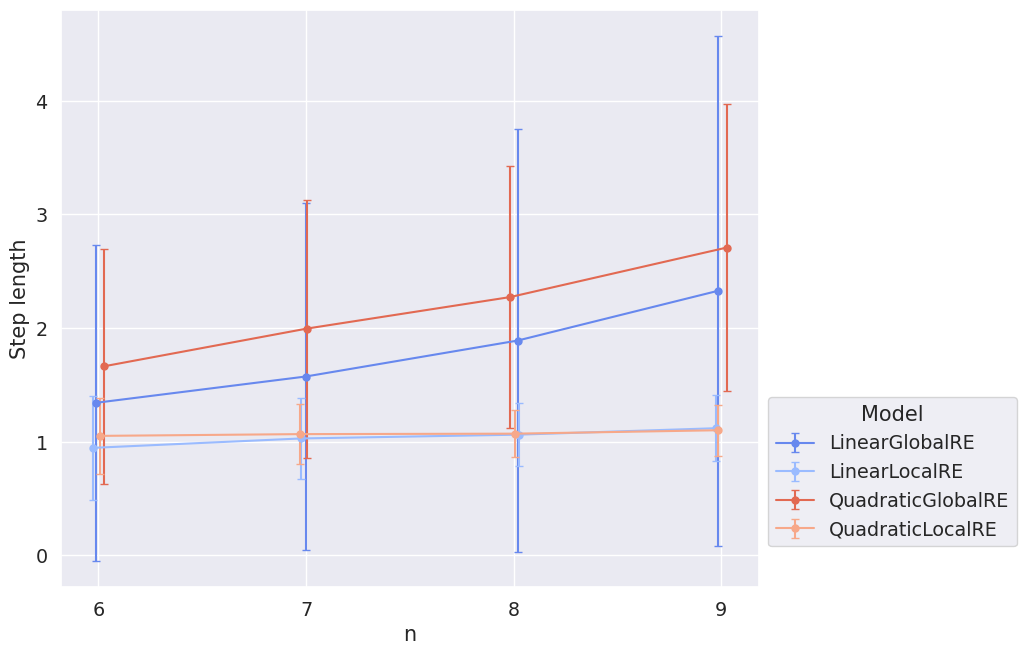

In [20]:
plot_multiple_error_bars(data=re_data, 
                         var_y='mean_step_size_coms', 
                         ylabel='Step length',
                         file_name=None if on_colab else 'step-length', 
                         output_dir=figures_output_dir)

## Distance init coms to fixed points coms

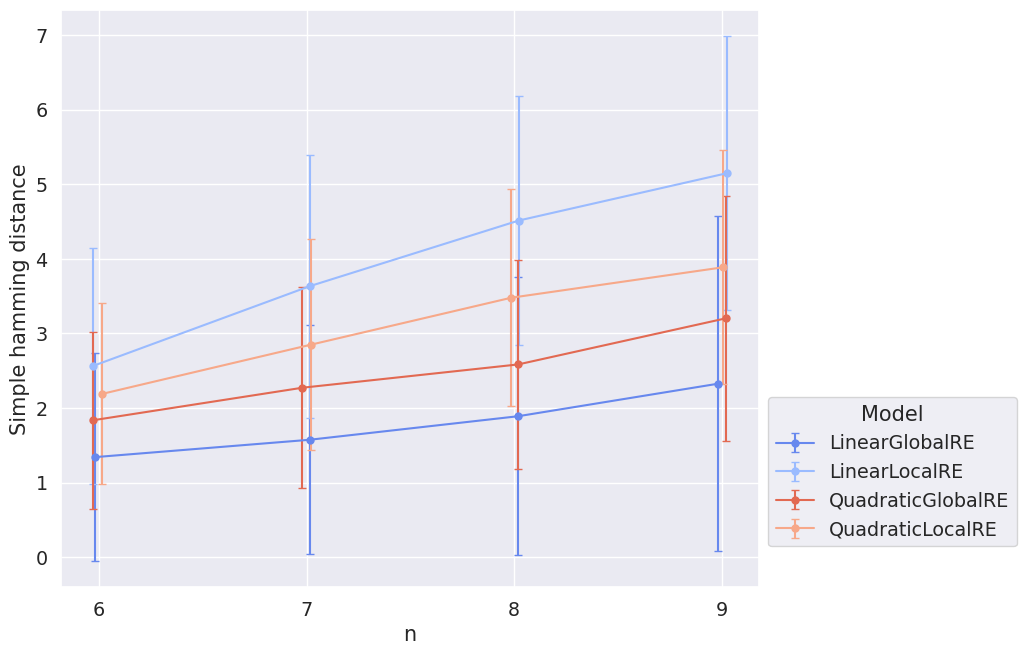

In [21]:
# init_final_coms_simple_hamming
plot_multiple_error_bars(data=re_data, 
                         var_y='init_final_coms_simple_hamming', 
                         ylabel='Simple hamming distance',
                         file_name=None if on_colab else 'distance-init-final-coms', 
                         output_dir=figures_output_dir)

## Global optima

### Number of global optima

In [13]:
cols_group_branches = ['model_name','ds','init_coms', 'weight_account', 'weight_systematicity'] 
data_collapsed = re_data.drop_duplicates(cols_group_branches)

In [14]:
data_collapsed.groupby('model_name')['n_global_optima'].describe()

,count,mean,std,min,25%,50%,75%,max
model_name,,,,,,,,
LinearGlobalRE,143973.0,4.867788,25.974363,1.0,1.0,2.0,4.0,1177.0
LinearLocalRE,142219.0,5.070321,30.153085,1.0,1.0,2.0,4.0,1386.0
QuadraticGlobalRE,143964.0,4.963630,14.337151,1.0,1.0,2.0,4.0,770.0
QuadraticLocalRE,143079.0,4.957324,14.476574,1.0,1.0,2.0,4.0,700.0


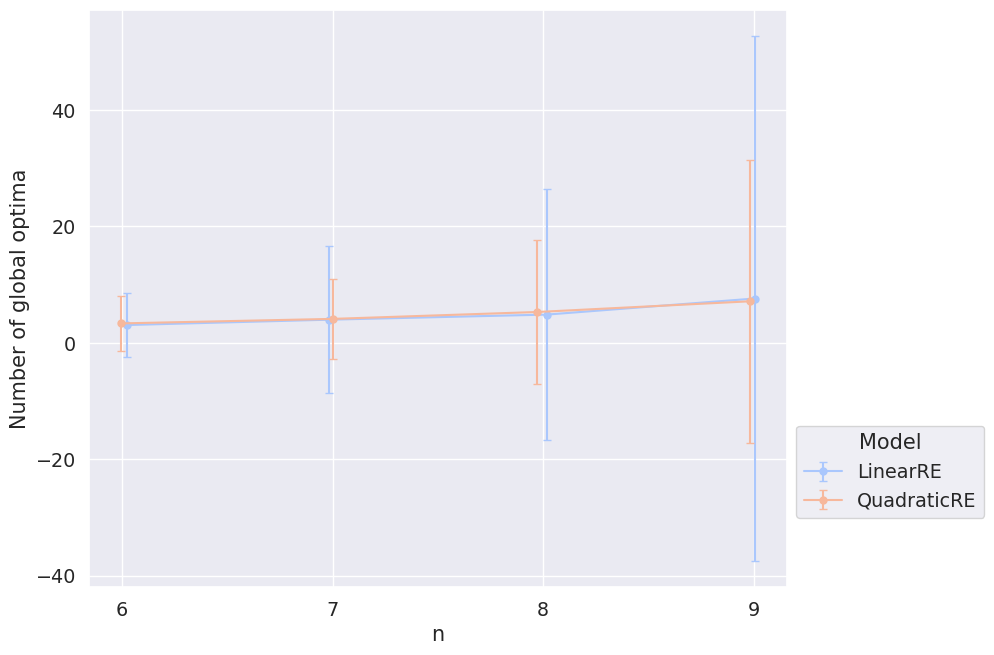

In [15]:
# n_global_optima (by model)
plot_multiple_error_bars(data=data_collapsed.loc[(data_collapsed['model_name']=='QuadraticGlobalRE') | (data_collapsed['model_name']=='LinearGlobalRE')], 
                         var_y='n_global_optima', 
                         ylabel='Number of global optima',
                         alt_labels={'QuadraticGlobalRE':'QuadraticRE', 'LinearGlobalRE':'LinearRE'},
                         file_name=None if on_colab else 'number-global-optima', 
                         output_dir=figures_output_dir)


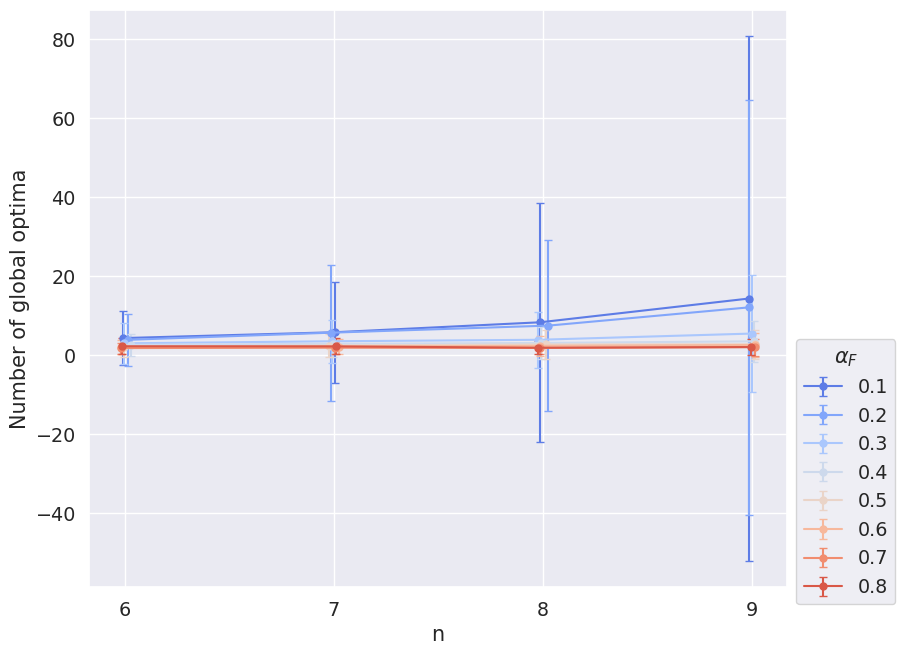

In [17]:
# n_global_optima (by alpha_f)
plot_multiple_error_bars(data=data_collapsed, 
                         var_y='n_global_optima', 
                         ylabel='Number of global optima',
                         var_hue='weight_faithfulness', 
                         hue_title=r'$\alpha_F$', 
                         #hue_title='alpha_F', 
                         
                         file_name=None if on_colab else 'number_global_optima', 
                         output_dir=figures_output_dir)


/home/kit/itz/nq5703/.conda/envs/bc-py39/lib/python3.9/site-packages/re_technical_report/data_analysis_helper_fun.py:228: FutureWarning: The provided callable <function mean at 0x14cce55e05e0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  mask = pd.pivot_table(re_data, index=[index], columns=columns,
/home/kit/itz/nq5703/.conda/envs/bc-py39/lib/python3.9/site-packages/re_technical_report/data_analysis_helper_fun.py:205: FutureWarning: The provided callable <function std at 0x14cce55e0700> is currently using DataFrameGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  x_std = pd.pivot_table(data, index=[index], columns=columns,
/home/kit/itz/nq5703/.conda/envs/bc-py39/lib/python3.9/site-packages/re_technical_report/data_analysis_helper_fun.py:207: FutureWarning: Da

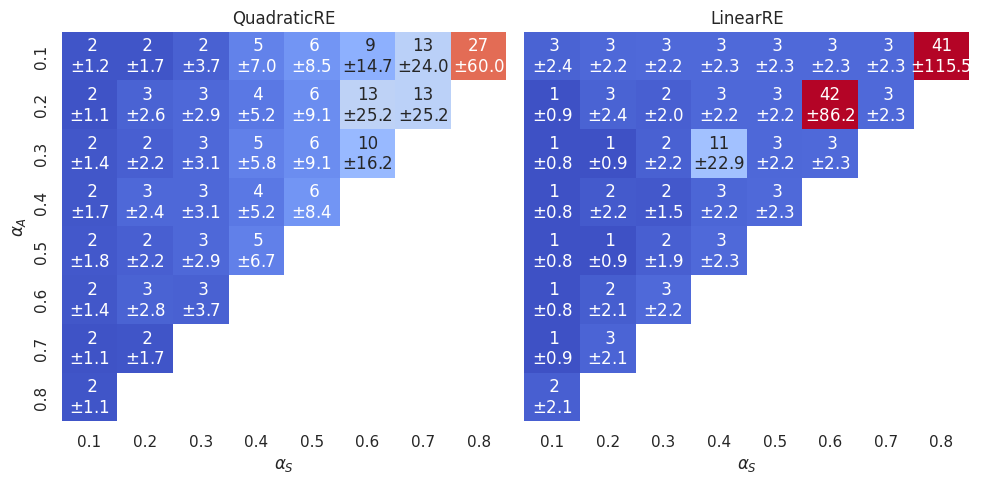

In [18]:
heat_maps_by_weights(re_data = data_collapsed.loc[(data_collapsed['model_name']=='QuadraticGlobalRE') | (data_collapsed['model_name']=='LinearGlobalRE')], 
                     values = 'n_global_optima', 
                     #title = 'Mean number of global optima', 
                     annot_std = True, annot_std_fmt = r'$\pm${:2.1f}', vmin=1, vmax=32,
                     col_model='q_or_l_model',
                     file_name=None if on_colab else 'hm-mean-n-global-optima', 
                     output_dir=figures_output_dir)

### Mean distance of global optima

We calculate the mean (simple Hamming) distance of global optima for those simulation setups that 
have more than one global optimum. Accordingly, it is important to know the extent of non-unique global optima
in simulation setup to interpret the results.

In [46]:
# calculating the mean distance (rows with only one go will receive NaN/None as value)
re_data['distance_go'] = re_data.apply(lambda x: mean_simple_hamming_distance([go_coms for go_theory, go_coms in x['global_optima']]), axis=1) 
# one row per simulation setup
cols_group_branches = ['model_name','ds','init_coms', 'weight_account', 'weight_systematicity'] 
data_collapsed = re_data.drop_duplicates(cols_group_branches)

In [47]:
# share of simulation setups that have more than one global optimum 
sum(data_collapsed['distance_go'].notna())/len(data_collapsed)

0.5789021954346821

In [48]:
# share of simulation setups that have more than one global optimum (for each model) 
data_collapsed.groupby('model_name').agg({'distance_go': lambda x: sum(x.notna())/len(x)})

,distance_go
model_name,
LinearGlobalRE,0.539198
LinearLocalRE,0.537354
QuadraticGlobalRE,0.619731
QuadraticLocalRE,0.619071


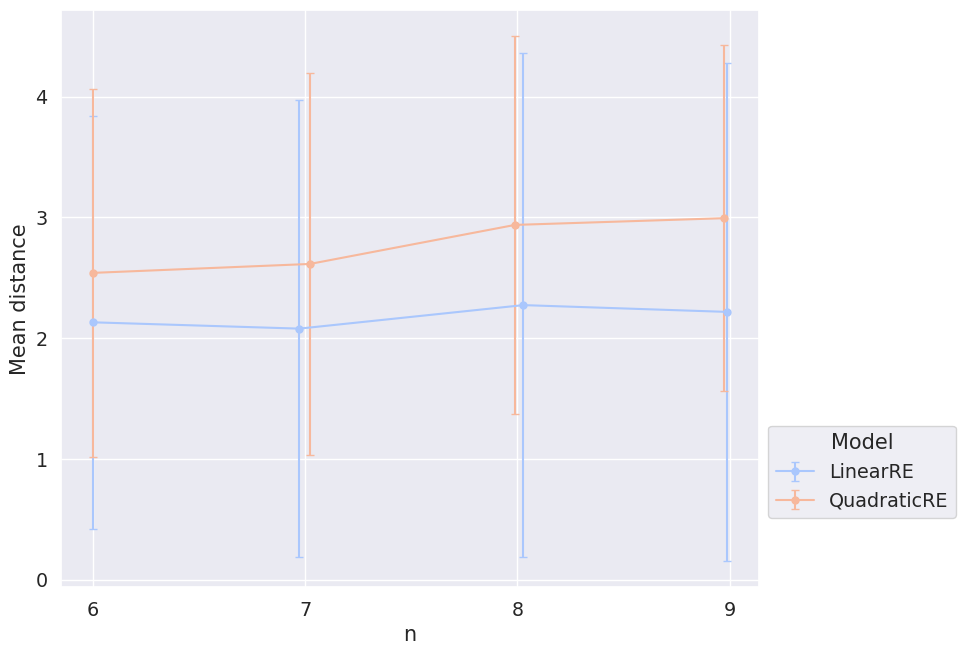

In [49]:
# by model
plot_multiple_error_bars(data=data_collapsed.loc[(data_collapsed['model_name']=='QuadraticGlobalRE') | (data_collapsed['model_name']=='LinearGlobalRE')], 
                         var_y='distance_go', 
                         ylabel='Mean distance',
                         alt_labels={'QuadraticGlobalRE':'QuadraticRE', 'LinearGlobalRE':'LinearRE'},
                         file_name=None if on_colab else 'mean-distance-global-optima-n', 
                         output_dir=figures_output_dir)


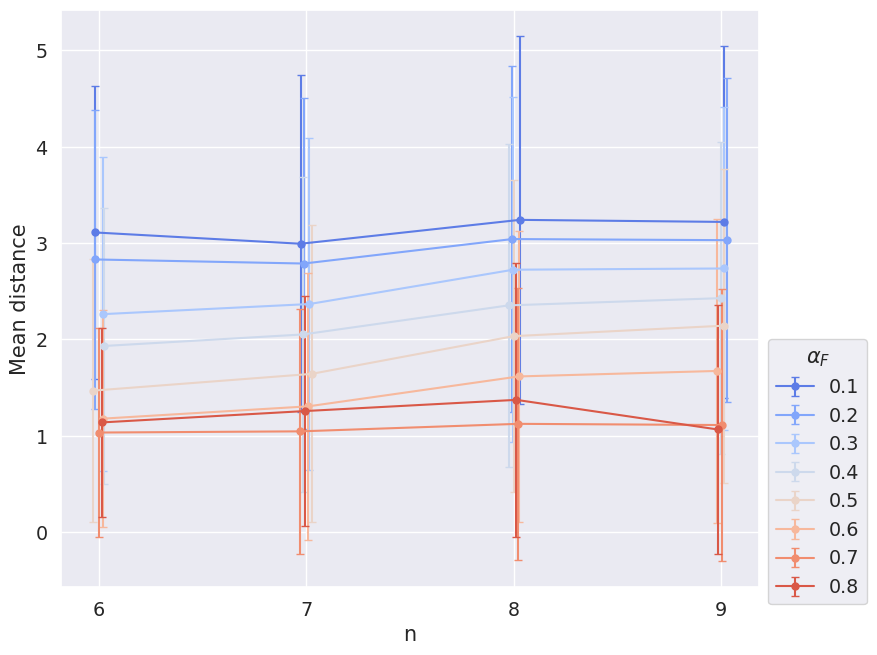

In [50]:
# by alpha_f
plot_multiple_error_bars(data=data_collapsed, 
                         var_y='distance_go', 
                         ylabel='Mean distance',
                         var_hue='weight_faithfulness', 
                         hue_title=r'$\alpha_F$', 
                         file_name=None if on_colab else 'mean-distance-global-optima-al', 
                         output_dir=figures_output_dir)                         

/home/kit/itz/nq5703/.conda/envs/bc-py39/lib/python3.9/site-packages/re_technical_report/data_analysis_helper_fun.py:227: FutureWarning: The provided callable <function mean at 0x14bf5d16f5e0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  mask = pd.pivot_table(re_data, index=[index], columns=columns,
/home/kit/itz/nq5703/.conda/envs/bc-py39/lib/python3.9/site-packages/re_technical_report/data_analysis_helper_fun.py:200: FutureWarning: The provided callable <function mean at 0x14bf5d16f5e0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  x_mean = pd.pivot_table(data, index=[index], columns=columns,
/home/kit/itz/nq5703/.conda/envs/bc-py39/lib/python3.9/site-packages/re_technical_report/data_analysis_helper_fun.py:204: FutureWarning

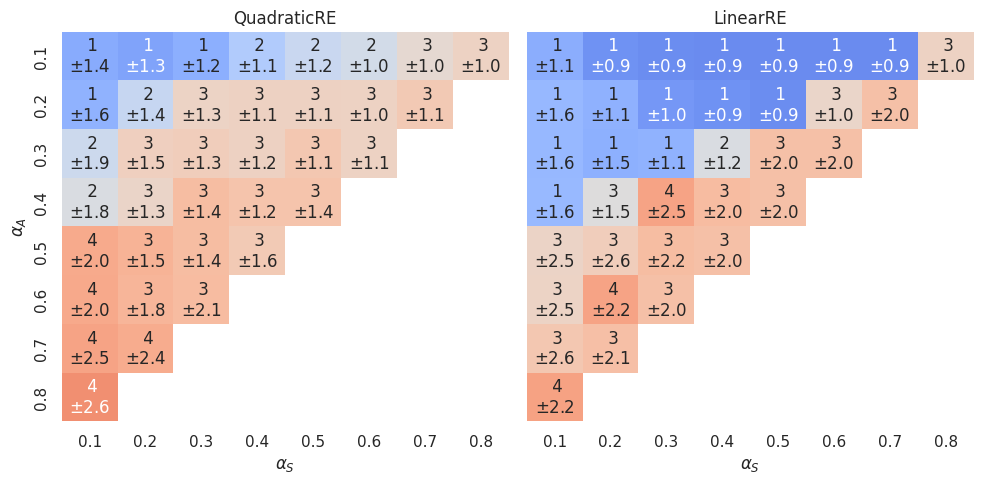

In [51]:
heat_maps_by_weights(re_data = data_collapsed.loc[(data_collapsed['model_name']=='QuadraticGlobalRE') | (data_collapsed['model_name']=='LinearGlobalRE')], 
                     values = 'distance_go', 
                     #title = 'Mean distance', 
                     col_model='q_or_l_model',
                     annot_std = True, annot_std_fmt = r'$\pm${:2.1f}', 
                     vmin=0, vmax=5,
                     file_name=None if on_colab else 'hm-mean-distance-global-optima', 
                     output_dir=figures_output_dir)

### Distance initital and global optima commitments

In [52]:
# mean distance of go commitments to initial commitments
re_data['mean_distance_init_coms_go'] = re_data.apply(mean_d_init_coms_go, axis=1)

In [53]:
# restrict data to unique simulation setups to prevent multiple counting of branches 
cols_group_branches = ['model_name','ds','init_coms', 'weight_account', 'weight_systematicity'] 
data_collapsed = re_data.drop_duplicates(cols_group_branches)

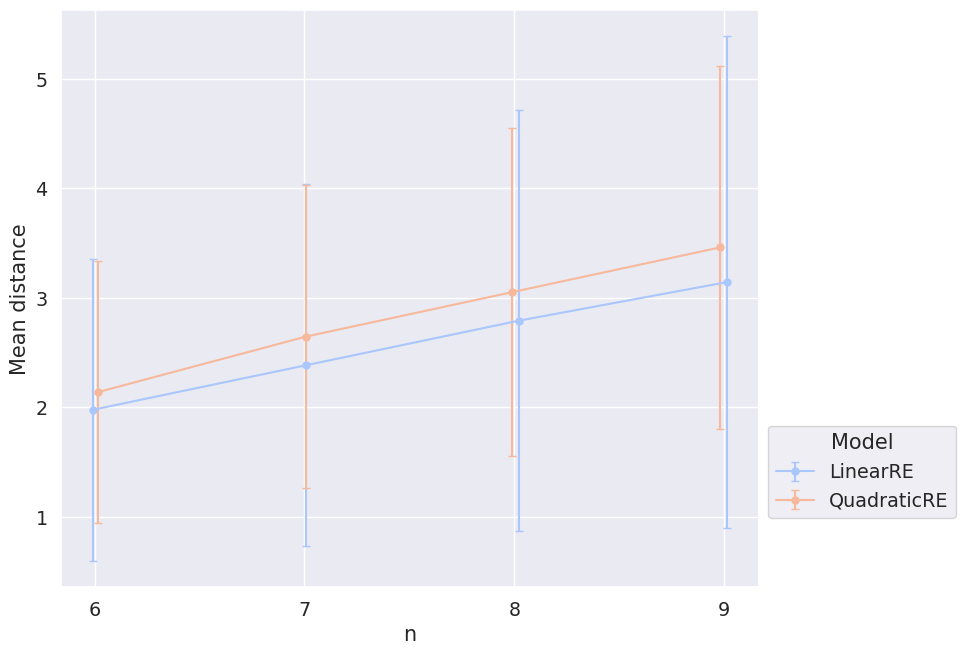

In [54]:
plot_multiple_error_bars(data=data_collapsed.loc[(data_collapsed['model_name']=='QuadraticGlobalRE') | (data_collapsed['model_name']=='LinearGlobalRE')], 
                         var_y='mean_distance_init_coms_go', 
                         ylabel='Mean distance',
                         alt_labels={'QuadraticGlobalRE':'QuadraticRE', 'LinearGlobalRE':'LinearRE'},
                         file_name=None if on_colab else 'distance-go-coms-n',
                         output_dir=figures_output_dir)

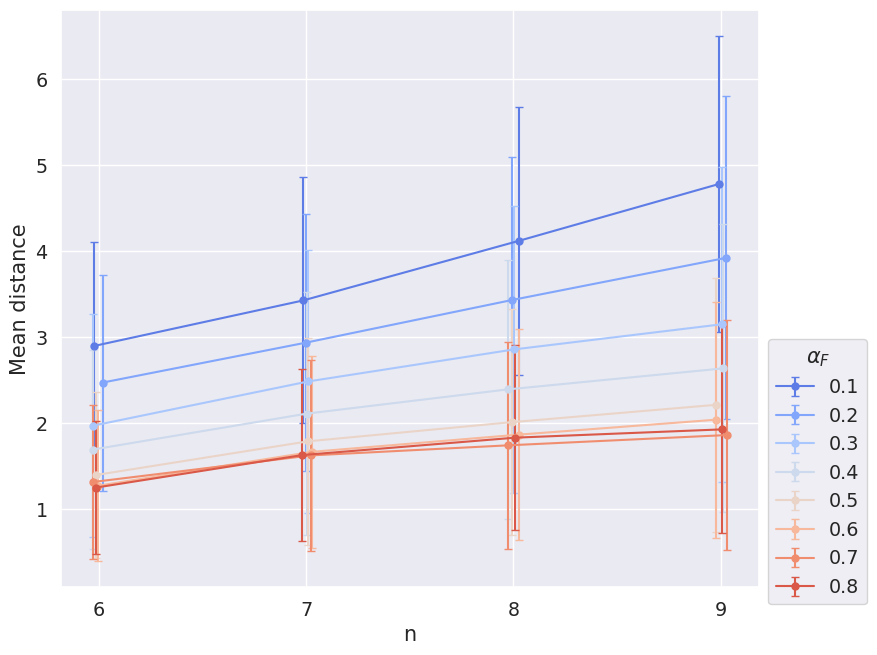

In [55]:
plot_multiple_error_bars(data=data_collapsed, 
                         var_y='mean_distance_init_coms_go', 
                         ylabel='Mean distance',
                         var_hue='weight_faithfulness', 
                         hue_title=r'$\alpha_F$', 
                         file_name=None if on_colab else 'distance-go-coms-al',
                         output_dir=figures_output_dir)

/home/kit/itz/nq5703/.conda/envs/bc-py39/lib/python3.9/site-packages/re_technical_report/data_analysis_helper_fun.py:227: FutureWarning: The provided callable <function mean at 0x14bf5d16f5e0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  mask = pd.pivot_table(re_data, index=[index], columns=columns,
/home/kit/itz/nq5703/.conda/envs/bc-py39/lib/python3.9/site-packages/re_technical_report/data_analysis_helper_fun.py:200: FutureWarning: The provided callable <function mean at 0x14bf5d16f5e0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  x_mean = pd.pivot_table(data, index=[index], columns=columns,
/home/kit/itz/nq5703/.conda/envs/bc-py39/lib/python3.9/site-packages/re_technical_report/data_analysis_helper_fun.py:204: FutureWarning

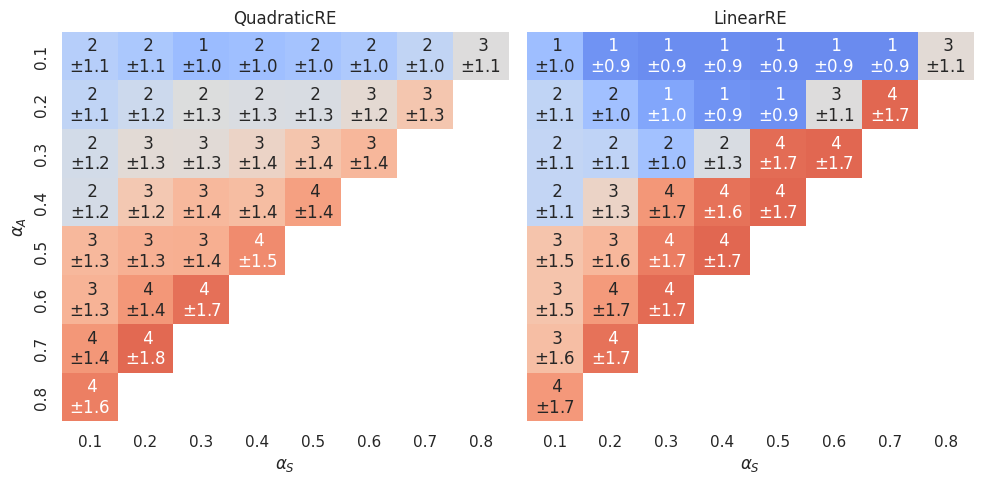

In [56]:
heat_maps_by_weights(re_data = data_collapsed.loc[(data_collapsed['model_name']=='QuadraticGlobalRE') | (data_collapsed['model_name']=='LinearGlobalRE')], 
                     values = 'mean_distance_init_coms_go', 
                     #title = 'Distance initial and go commitments', 
                     col_model='q_or_l_model',
                     annot_std = True, annot_std_fmt = r'$\pm${:2.1f}', 
                     vmin=0, vmax=5,
                     file_name=None if on_colab else 'hm-mean-distance-init-coms-go', 
                     output_dir=figures_output_dir)

## Branches

### Counting fixed points

In [19]:
cols_group_branches = ['model_name','ds','init_coms', 'weight_account', 'weight_systematicity'] 
data_collapsed = re_data.drop_duplicates(cols_group_branches)

In [20]:
data_collapsed.groupby('model_name')['n_fixed_points'].describe()

,count,mean,std,min,25%,50%,75%,max
model_name,,,,,,,,
LinearGlobalRE,143973.0,2.172512,3.649524,1.0,1.0,1.0,2.0,192.0
LinearLocalRE,142219.0,1.604019,2.027091,1.0,1.0,1.0,1.0,67.0
QuadraticGlobalRE,143964.0,3.182372,7.851437,1.0,1.0,2.0,3.0,439.0
QuadraticLocalRE,143079.0,4.111267,5.451744,1.0,1.0,3.0,4.0,133.0


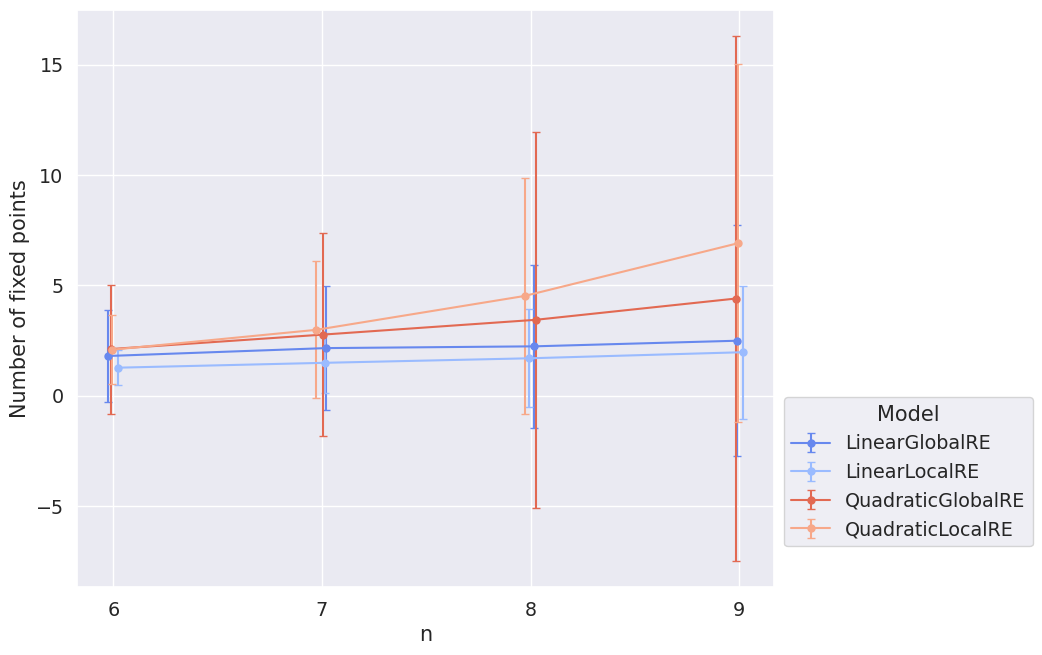

In [21]:
# n_fixed_points (by model)
plot_multiple_error_bars(data=data_collapsed, 
                         var_y='n_fixed_points', 
                         ylabel='Number of fixed points',
                         file_name=None if on_colab else 'number_fixed_points', 
                         output_dir=figures_output_dir)


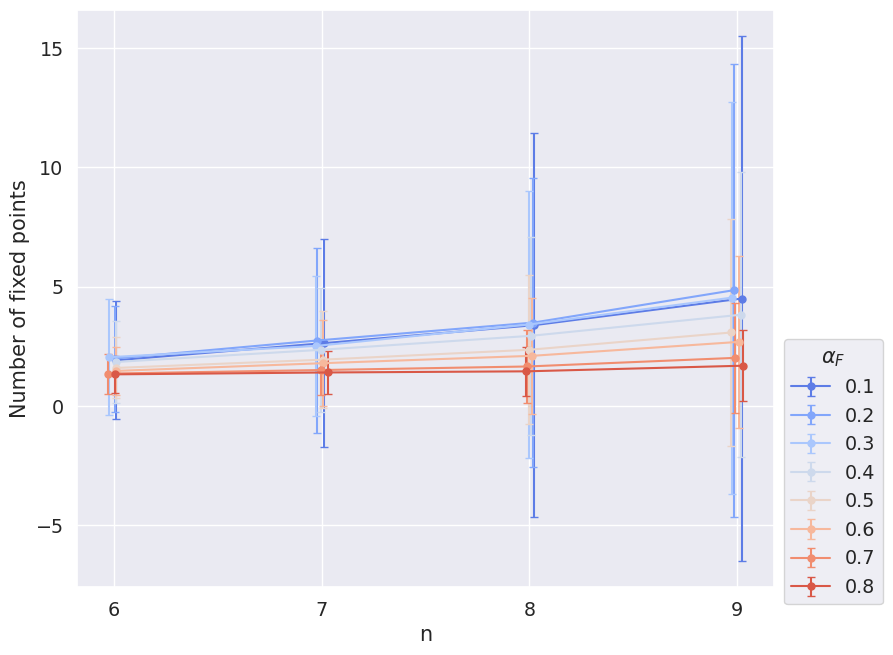

In [22]:
# n_fixed_points (by alpha_f)
plot_multiple_error_bars(data=data_collapsed, 
                         var_y='n_fixed_points', 
                         ylabel='Number of fixed points',
                         var_hue='weight_faithfulness', 
                         hue_title=r'$\alpha_F$', 
                         file_name=None if on_colab else 'number_global_optima', 
                         output_dir=figures_output_dir)


/home/kit/itz/nq5703/.conda/envs/bc-py39/lib/python3.9/site-packages/re_technical_report/data_analysis_helper_fun.py:228: FutureWarning: The provided callable <function mean at 0x14cce55e05e0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  mask = pd.pivot_table(re_data, index=[index], columns=columns,
/home/kit/itz/nq5703/.conda/envs/bc-py39/lib/python3.9/site-packages/re_technical_report/data_analysis_helper_fun.py:205: FutureWarning: The provided callable <function std at 0x14cce55e0700> is currently using DataFrameGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  x_std = pd.pivot_table(data, index=[index], columns=columns,
/home/kit/itz/nq5703/.conda/envs/bc-py39/lib/python3.9/site-packages/re_technical_report/data_analysis_helper_fun.py:207: FutureWarning: Da

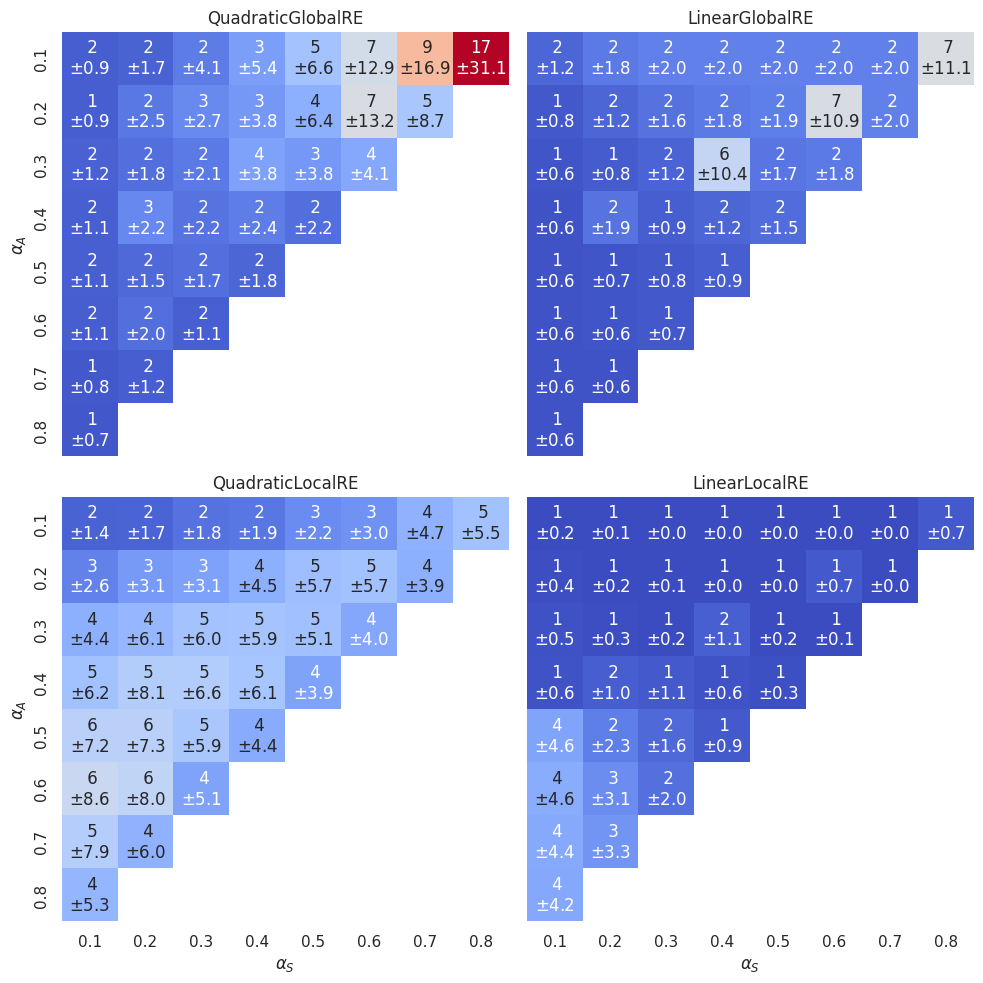

In [23]:
heat_maps_by_weights(re_data = data_collapsed, 
                     values = 'n_fixed_points', 
                     #title = 'Mean number of fixed points', 
                     annot_std = True, annot_std_fmt = r'$\pm${:2.1f}', vmin=1, vmax=13,
                     file_name=None if on_colab else 'hm-mean-n-fixed-points', 
                     output_dir=figures_output_dir)

### Counting branches

In [24]:
# Cols that should have identical values for all branches (and only for those) that belong to one branching model run
cols_group_branches = ['model_name', 'ds','init_coms', 'weight_account', 'weight_systematicity', 'weight_faithfulness', 'n_sentence_pool'] 
#cols_group_branches = ['model_name', 'model_short_name', 'ds','init_coms', 'weight_account', 'weight_systematicity', 'weight_faithfulness'] 

# Calculating the number of branches for each model run
df_branches = DataFrame({'n_branches' : re_data.groupby(cols_group_branches).size()}).reset_index()

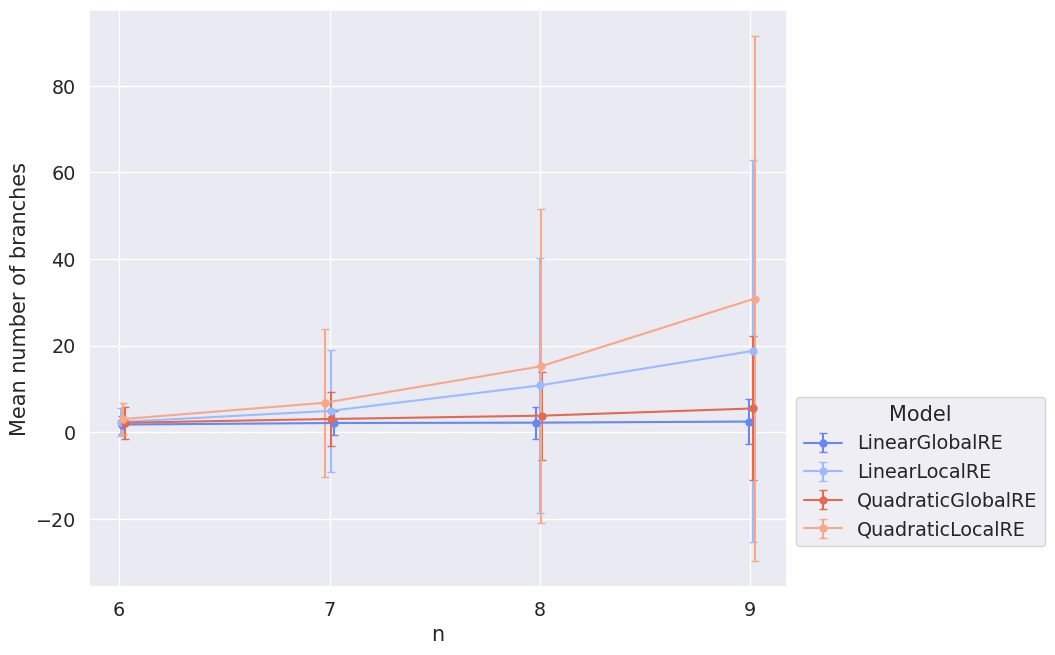

In [25]:
plot_multiple_error_bars(data=df_branches, 
                         var_y='n_branches', 
                         ylabel='Mean number of branches',
                         file_name=None if on_colab else 'mean-branches', 
                         output_dir=figures_output_dir)

/home/kit/itz/nq5703/.conda/envs/bc-py39/lib/python3.9/site-packages/re_technical_report/data_analysis_helper_fun.py:228: FutureWarning: The provided callable <function mean at 0x14cce55e05e0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  mask = pd.pivot_table(re_data, index=[index], columns=columns,
/home/kit/itz/nq5703/.conda/envs/bc-py39/lib/python3.9/site-packages/re_technical_report/data_analysis_helper_fun.py:205: FutureWarning: The provided callable <function std at 0x14cce55e0700> is currently using DataFrameGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  x_std = pd.pivot_table(data, index=[index], columns=columns,
/home/kit/itz/nq5703/.conda/envs/bc-py39/lib/python3.9/site-packages/re_technical_report/data_analysis_helper_fun.py:207: FutureWarning: Da

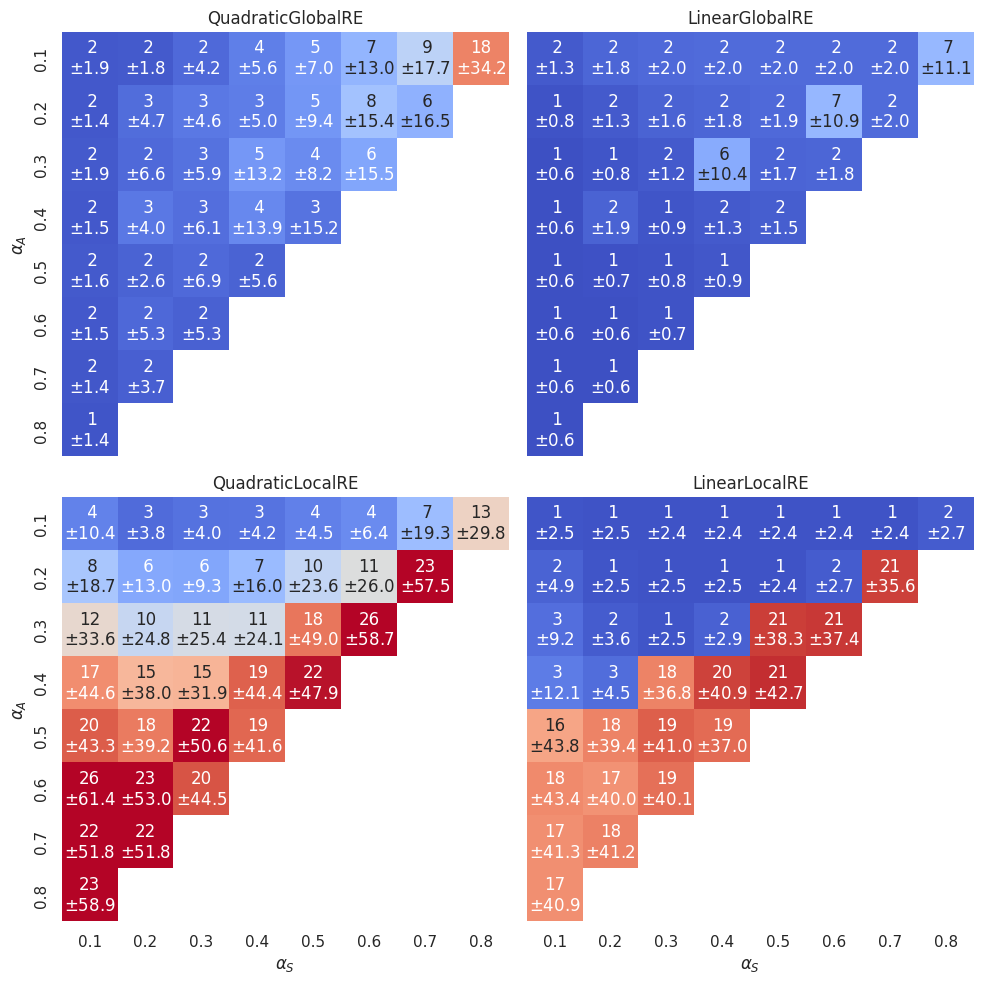

In [26]:
heat_maps_by_weights(re_data = df_branches, values = 'n_branches', 
                     #title = 'Mean number of branches', 
                     annot_std = True, annot_std_fmt = r'$\pm${:2.1f}', vmin=1, vmax=22,
                     file_name=None if on_colab else 'hm-mean-branches', 
                     output_dir=figures_output_dir,
                     col_order=['QuadraticGlobalRE', 'LinearGlobalRE', 
                                'QuadraticLocalRE', 'LinearLocalRE' ])

## to del


In [27]:
import random


def plot_multiple_error_bars(data, var_y, ylabel,  
                             var_hue = 'model_name', hue_title='Model',
                             var_std = None,
                             var_x = 'n_sentence_pool', xlabel = 'n', xticks=[6,7,8,9],
                             file_name=None, output_dir=None,
                             jitter=True, jitter_size=0.03,
                             bbox_to_anchor=(1., 0.2),
                             alt_labels=None):
    
    n_hues = data[var_hue].nunique()
    set_errorbar_plot_style(n_hues, models=var_hue=="model_name")
    
    # If no col for error bars is given, we assume that the data is not aggregated and use `describe()` to do so
    if var_std is None:
        groupby = [var_hue] + [var_x]
        data_summary = data.groupby(groupby)[var_y].describe().reset_index()
        var_y = 'mean'
        var_std ='std'
    else:
        data_summary = data
    
    if jitter:
        data_summary[var_x] = data_summary.apply(lambda x: x[var_x]+random.uniform(-jitter_size, jitter_size), axis=1)
        
    #sns.set(font_scale=1.25)

    for name, group in data_summary.groupby(var_hue):
        if alt_labels:
            name=alt_labels[name]
        plt.errorbar(group[var_x], 
                     group[var_y],
                     yerr=group[var_std],
                     marker='o', 
                     #linestyle='', # providing an empty string omits lines 
                     markersize=5,
                     capsize=3,
                     label=str(name))

    plt.legend(loc='center left', bbox_to_anchor=bbox_to_anchor, ncol=1, title=hue_title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.xticks(xticks)
    
    if (file_name is not None) and (output_dir is not None):
        plt.savefig(path.join(output_dir, file_name + '.pdf'), bbox_inches='tight')
        plt.savefig(path.join(output_dir, file_name + '.png'), bbox_inches='tight')
